In [98]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

### Libs

In [124]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# plot the regression fit for comparison
def plot_fit(feature, target, coefficients, intercept):
    plt.scatter(feature, target,  color='blue')
    xi = np.arange(0.0, 1.0, 0.1)
    line = coefficients * xi + [[intercept]]
    plt.plot(xi, line[0])
    return plt

### Data

In [100]:
# we fake some events with good correlation
N_EVENTS = 100
feature = np.random.rand(N_EVENTS)
target = feature + np.random.rand(N_EVENTS)*0.2
df = pd.DataFrame(data = zip(feature, target), columns=['feature', 'target'])
df.head(3)

,feature,target
0,0.374540,0.380826
1,0.950714,1.077996
2,0.731994,0.794865


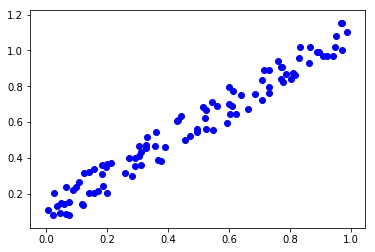

In [101]:
plt.scatter(feature, target, color='blue')
plt.show()

### Prepare Data for Tensor Flow

In [102]:
m = N_EVENTS
n = 1 # one feature

data_plus_bias = np.c_[np.ones((m, 1)), feature]
X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(target.reshape(-1, 1), dtype=tf.float32, name="y")

### => regression with scikit (for comparisons)

In [128]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(np.c_[feature], target)
intercept = lin_reg.intercept_.reshape(-1, 1)[0][0]
coefficients = lin_reg.coef_.T
print "coefficients (slope): ", coefficients
print "intercept: ", intercept

coefficients (slope):  [0.99329367]
intercept:  0.10271953128020728


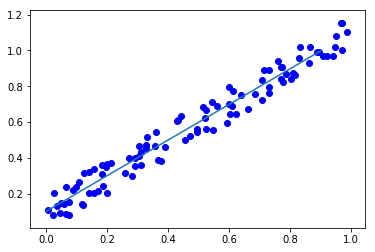

In [129]:
plot_fit(feature, target, coefficients, intercept).show()

### => regression using Normal Equation

coefficients (slope):  [0.99329287]
intercept:  0.1027199


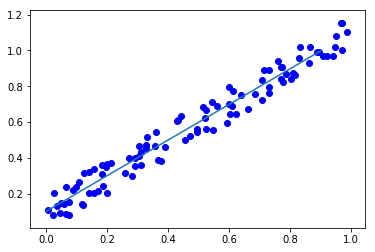

In [133]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
intercept, coefficients = theta_value
intercept = intercept[0]
print "coefficients (slope): ", coefficients
print "intercept: ", intercept
plot_fit(feature, target, coefficients, intercept).show()

### => regression using Tensor Flow Estimator 

In [238]:
# create placeholders for input X (number of fire) and label Y (number of theft)
X  =  tf.placeholder(tf.float32 ,  name = "X")
Y  =  tf.placeholder(tf.float32 ,  name = "Y")
# create weight and bias, initialized to 0
w  =  tf.Variable(0.0, name = "weights") 
b  =  tf.Variable(0.0,  name = "bias")
# construct model to predict Y 
Y_predicted  =  X  *  w  +  b
# use the square error as the loss function
loss  =  tf.square(Y- Y_predicted ,  name = "loss")
# we could use here the mse too
# mse = tf.reduce_mean(tf.square(Y- Y_predicted), name="mse")

# using gradient descent with learning rate of 0.01 to minimize loss
optimizer  =  tf.train.GradientDescentOptimizer( learning_rate = 0.001 ).minimize(loss)

with  tf.Session ()   as  sess:
    #initialize the necessary variables, in this case, w and b 
    sess.run(tf.global_variables_initializer())
    # train the model
    # run 100 epochs 
    for  i  in  range (100):  
        for  x ,  y  in  zip(feature, target):
            # Session runs train_op to minimize loss
            sess.run(optimizer ,  feed_dict ={ X :  x ,  Y : y })
    # Step 9: output the values of w and b
    w_value ,  b_value  =  sess.run ([ w ,  b ])
    
coefficients
print "coefficients (slope): ", w_value
print "intercept: ", b_value
plot_fit(feature, target, coefficients, intercept).show()

0.8120035 0.19490708


### => regression using Batch Gradient Descent

In [176]:
# Gradient Descent requires scaling the feature vectors first. 
# We could do this using TF, but let's just use Scikit-Learn for now.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(np.c_[feature])
m = len(feature)
scaled_X_plus_bias = np.concatenate((np.ones((m, 1)), scaled_X), axis=1)
pd.DataFrame(data = np.concatenate((scaled_X_plus_bias, np.c_[target]), axis=1), 
             columns=['feature', 'bias', 'target'])
df.head(3)

,feature,target
0,0.374540,0.380826
1,0.950714,1.077996
2,0.731994,0.794865


In [229]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_X_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(target.reshape(-1, 1), dtype=tf.float32, name="y")
m, n = scaled_X.shape
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2./m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
best_theta

('Epoch', 0, 'MSE =', 1.1195977)
('Epoch', 100, 'MSE =', 0.023029918)
('Epoch', 200, 'MSE =', 0.0037435465)
('Epoch', 300, 'MSE =', 0.0034043354)
('Epoch', 400, 'MSE =', 0.003398369)
('Epoch', 500, 'MSE =', 0.0033982643)
('Epoch', 600, 'MSE =', 0.003398263)
('Epoch', 700, 'MSE =', 0.003398262)
('Epoch', 800, 'MSE =', 0.003398262)
('Epoch', 900, 'MSE =', 0.003398262)


array([[0.56974566],
       [0.29401243]], dtype=float32)

coefficients (slope):  [0.56974566]
intercept:  0.29401243


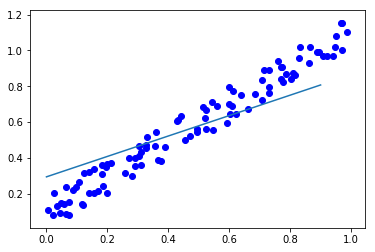

In [230]:
coefficients, intercept = best_theta
intercept = intercept[0]
print "coefficients (slope): ", coefficients
print "intercept: ", intercept
plot_fit(feature, target, coefficients, intercept).show()

### => regression using Batch Gradient Descent & Autodiff

In [231]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_X_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(target.reshape(-1, 1), dtype=tf.float32, name="y")
m, n = scaled_X.shape
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2./m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

('Epoch', 0, 'MSE =', 1.1195977)
('Epoch', 100, 'MSE =', 0.023029923)
('Epoch', 200, 'MSE =', 0.0037435489)
('Epoch', 300, 'MSE =', 0.0034043354)
('Epoch', 400, 'MSE =', 0.003398369)
('Epoch', 500, 'MSE =', 0.0033982643)
('Epoch', 600, 'MSE =', 0.003398263)
('Epoch', 700, 'MSE =', 0.003398262)
('Epoch', 800, 'MSE =', 0.003398262)
('Epoch', 900, 'MSE =', 0.003398262)
Best theta:
[[0.56974566]
 [0.29401243]]


### => regression using Batch Gradient Descent & Autodiff & optimizer

In [ ]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

